# **Experiment with multiple models**
#### 이 파일은 stockait 라이브러리를 이용하여 같은 방법으로 전처리된 데이터를 사용하는 서로다른 인공지능 모델들을 학습하여 각 모델에 대한 성능과 수익률을 비교하는 예시를 보여준다. 

<br> 


In [1]:
import sys
sys.path.append("/project/stockAI/github/main/stockait")
import stockait as sai
import pandas as pd

--------

<br> 

# 1. **Load Data**

#### 데이터 로드 및 전처리 과정은 생략하고, `00.demo.ipynb` 파일 에서 저장한 데이터로 실험을 진행한다.  
#### 데이터는 다음의 두 가지가 존재한다. 
- time_series_0903.parquet 
- time_series_0903_scaled.parquet (스케일링 적용 데이터 / div-close 방법) 

#### 스케일링을 제외하고는 모두 같은 방법으로 전처리가 적용되어있다. 

In [2]:
df_time_series = pd.read_parquet("../time_series_0903.parquet") 
df_time_series_scaled = pd.read_parquet("../time_series_0903_scaled.parquet")

df_time_series['Code'] = df_time_series['Code'].astype(str).str.zfill(6)
df_time_series_scaled['Code'] = df_time_series_scaled['Code'].astype(str).str.zfill(6)

In [3]:
print(df_time_series.shape) 
df_time_series.head()

(1045449, 483)


,Code,Date,D-9_Open,D-9_High,D-9_Low,D-9_Close,D-9_Volume,D-9_Change,D-9_MA5,D-9_MA20,...,D0_TSI,D0_UO,D0_SR,D0_WR,D0_AO,D0_KAMA,D0_ROC,D0_PPO,D0_PVO,next_change
index,,,,,,,,,,,,,,,,,,,,,
0,000020,2017-01-02,8000,8020,7880,7980,29259,-0.002500,7928.0,7773.0,...,8.733155,63.290816,86.956522,-13.043478,142.823529,7862.703851,2.658228,0.653934,-1.629817,0.000000
1,000020,2017-01-03,7980,8000,7830,7920,25678,-0.007519,7948.0,7770.0,...,10.392942,64.061001,86.363636,-13.636364,183.794118,7872.320017,2.141058,0.753873,-5.174549,0.004932
2,000020,2017-01-04,7880,7960,7830,7900,34333,-0.002525,7948.0,7768.5,...,12.273619,67.101325,91.111111,-8.888889,219.529412,7898.574543,1.875000,0.862988,-1.907365,0.007362
3,000020,2017-01-05,7900,7910,7740,7800,49362,-0.012658,7920.0,7766.5,...,14.587203,64.966439,92.156863,-7.843137,255.705882,7941.330237,2.882206,0.997655,-2.485440,-0.006090
4,000020,2017-01-06,7800,7940,7760,7830,31948,0.003846,7886.0,7759.0,...,15.671728,60.791157,75.000000,-25.000000,285.500000,7985.928857,3.030303,1.041458,-3.459170,-0.009804


#### 날짜는 2017년 1월 1일 부터 2021년 12월 31일까지이며, 총 42개의 보조지표를 추가한 데이터이다. 또한 하나의 행에는 10일치의 주가 데이터, 보조지표 컬럼이 존재한다. Code, Date, next_change(종속변수)를 제외하고, 총 480개의 독립변수를 가지는 것을 볼 수 있다.   

### **train / validation / test 데이터셋 분리** 

In [4]:
data = df_time_series # Data Before Scaling
data_scaled = df_time_series_scaled # Data After Scaling

# train, validation, test dataset split
train_data = data[(data['Date'] >= '2017-01-01') & (data['Date'] <= '2020-12-31')]
valid_data = data[(data['Date'] >= '2021-01-01') & (data['Date'] <= '2021-06-31')] 
test_data = data[(data['Date'] >= '2021-07-01') & (data['Date'] <= '2021-12-31')]

# train, validation, test dataset split (scaled) 
train_data_scaled = data_scaled[(data_scaled['Date'] >= '2017-01-01') & (data_scaled['Date'] <= '2020-12-31')]
valid_data_scaled = data_scaled[(data_scaled['Date'] >= '2021-01-01') & (data_scaled['Date'] <= '2021-06-31')] 
test_data_scaled = data_scaled[(data_scaled['Date'] >= '2021-07-01') & (data_scaled['Date'] <= '2021-12-31')]

print(train_data.shape, valid_data.shape, test_data.shape)
print(train_data_scaled.shape, valid_data_scaled.shape, test_data_scaled.shape)

(828290, 483) (107068, 483) (110091, 483)
(828290, 483) (107068, 483) (110091, 483)


#### 2017년 부터 2020년을 학습 데이터셋으로, 2021년 6월까지 검증 데이터셋, 2021년 12월까지 시험 데이터셋으로 설정하여 분할했다. 

<br> 
<br> 


# **2. Trader Definition**

#### 데이터셋 준비를 마쳤으면 Trader들을 정의한다. 
#### 인공지능 모델은 LightGBM, XGBoost, RandomForest, LSTM, Transformer 모델을 사용하며, 아래에 선언한 빈 리스트 **lst_trader** 안에 추가하여 트레이더 단위로 작업을 수행한다. 

In [5]:
lst_trader = [] 

### * **GPU 설정**
#### 딥러닝 모델인 LSTM, Transformer를 위한 device를 설정한다.  

In [6]:
import os
import tensorflow as tf
import torch

# Tensorflow 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
        
# Pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2023-09-14 12:03:20.515890: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 12:03:20.910301: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-14 12:03:22.039930: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64::/usr/local/cuda-11.5/lib64:/usr/local/cuda-11.5/targets/x86_64-linux/lib
2023-09-14 12:03:22.040059: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dyna

<br> 

#### 아래에는 7개의 인공지능 모델들을 정의하고, lst_trader 안에 추가하는 코드가 나와있다. 
#### 자세한 Trader의 정의 방법은 이전 튜토리얼을 참고하기를 바란다. 

<br> 

## **1) LightGBM** 

In [7]:
from lightgbm import LGBMClassifier

# conditional_buyer: Object that determines acquisition based on data filtering conditions 
b1_lg = sai.ConditionalBuyer()

def sampling1(df): # Create a conditional function
    condition1 = (-0.3 <= df.D0_Change) & (df.D0_Change <= 0.3) # Remove exceptions that exceed upper and lower limits
    condition2 = (df.D0_Close * df.D0_Volume) >= 1000000000 # condition 1: Transaction amount of more than 1 billion won 
    # condition3 = (-0.05 >= df.D0_Change) | (0.05 <= df.D0_Change) # condition 2: Today's stock price change rate is more than 5%
    condition4 = (df.D0_CCI <= -100)
    condition = condition1 & condition2 & condition4
    return condition

b1_lg.condition = sampling1  # Define the condition function directly (sampling1) and store it in the condition property 


# machinelearning_buyer: Object that determines acquisition by machine learning model
b2_lg = sai.MachinelearningBuyer()

# Save user-defined models to algorithm properties
scale_pos_weight = round(72/28 , 2)
params = {  'random_state' : 42,
            'scale_pos_weight' : scale_pos_weight,
            'learning_rate' : 0.1, 
            'num_iterations' : 1000,
            'max_depth' : 4,
            'n_jobs' : 30,
            'boost_from_average' : False,
            'objective' : 'binary' }

b2_lg.algorithm =  LGBMClassifier( **params )


# SubSeller: Object that determines selling all of the following days
sell_all = sai.SubSeller() 


# Trader Object   
t1 = sai.Trader()
t1.name = 'saiLightGBM' # Trader's name
t1.label = 'class&0.02' # Set the Trader dependent variable (do not set if it is regression analysis) 
t1.buyer = sai.Buyer([b1_lg, b2_lg]) # [ conditional buyer, machinelearning buyer ] 
t1.seller = sai.Seller(sell_all)

lst_trader.append(t1)

<br> 

## **2) XGBoost** 

In [8]:
from xgboost import XGBClassifier

b1_xgb = sai.ConditionalBuyer() 

def sampling2(df): 
    condition1 = (-0.3 <= df.D0_Change) & (df.D0_Change <= 0.3) 
    condition2 = (df.D0_Close * df.D0_Volume) >= 1000000000 
    # condition3 = (-0.05 >= df.D0_Change) | (0.05 <= df.D0_Change) 
    condition4 = (df.D0_CCI <= -100)
    condition = condition1 & condition2 & condition4
    return condition

b1_xgb.condition = sampling2


b2_xgb = sai.MachinelearningBuyer()  

scale_pos_weight = round(72/28 , 2)
b2_xgb.algorithm = XGBClassifier(random_state = 42,
                   n_jobs=30,
                   scale_pos_weight=scale_pos_weight,
                   learning_rate=0.1,
                   max_depth=4,
                   n_estimators=1000,
                   )  

sell_all = sai.SubSeller()


t2 = sai.Trader()
t2.name = 'saiXGboost' 
t2.label = 'class&0.02' 
t2.buyer = sai.Buyer([b1_xgb, b2_xgb])
t2.seller = sai.Seller(sell_all) 

lst_trader.append(t2) 

<br> 

## **3) RandomForest** 

In [9]:
from sklearn.ensemble import RandomForestClassifier

b1_rf = sai.ConditionalBuyer()

def sampling3(df):  
    condition1 = (-0.3 <= df.D0_Change) & (df.D0_Change <= 0.3) 
    condition2 = (df.D0_Close * df.D0_Volume) >= 1000000000 
    # condition3 = (-0.05 >= df.D0_Change) | (0.05 <= df.D0_Change) 
    condition4 = (df.D0_CCI <= -100)
    condition = condition1 & condition2 & condition4
    return condition

b1_rf.condition = sampling3


b2_rf = sai.MachinelearningBuyer()  

b2_rf.algorithm = RandomForestClassifier() 


sell_all = sai.SubSeller() 


t3 = sai.Trader()
t3.name = 'saiRandomForest'  
t3.label = 'class&0.02' 
t3.buyer = sai.Buyer([b1_rf, b2_rf]) 
t3.seller = sai.Seller(sell_all)

lst_trader.append(t3) 

<br>

## **4) LSTM - Tensorflow/Keras** 

In [10]:
from tensorflow import keras
import numpy as np

b1_ls = sai.ConditionalBuyer()

def sampling4(df): 
    condition1 = (-0.3 <= df.D0_Change) & (df.D0_Change <= 0.3) 
    condition2 = (df.D0_Close * df.D0_Volume) >= 1000000000 
    condition3 = (-0.05 >= df.D0_Change) | (0.05 <= df.D0_Change) 
    condition = condition1 & condition2 & condition3
    return condition

b1_ls.condition = sampling4


b2_ls = sai.MachinelearningBuyer()

# ⭐ User-defined functions (users who want deep learning modeling)
def transform(data): # A function that converts into a two-dimensional structure / data: list (lst_time_series)
    data_2d = []
    n_col = int(len(data[0]) / 10) 
    for row in data:      
        data_2d.append([])
        for i in range(0, len(row), n_col):
            data_2d[-1].append(row[i:i+n_col])
    
    return np.array(data_2d)
    

# Directly define a two-dimensional structure transformation function (transform) and store it in the data_transform property
b2_ls.data_transform = transform 

# deep learning framework 
b2_ls.framework = "tensorflow"

# parameters for model.fit() 
b2_ls.params = {
    "epochs": 5, 
    "batch_size": 64,
    }

# defines a model 
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=(10, 48)))
model.add(keras.layers.LSTM(128, activation='selu', return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(64, activation='selu', return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(32, activation='selu', return_sequences=False))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))
    
model.compile(optimizer=keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.ExponentialDecay(0.05,decay_steps=100000,decay_rate=0.96)), 
    loss="binary_crossentropy",
    metrics=['accuracy'])

b2_ls.algorithm = model

sell_all = sai.SubSeller() 

t4 = sai.Trader()
t4.name = 'saiLSTM_tf' 
t4.label = 'class&0.02' 
t4.scaled_data = False 
t4.buyer = sai.Buyer([b1_ls, b2_ls]) 
t4.seller = sai.Seller(sell_all)

lst_trader.append(t4)

2023-09-12 15:40:45.363596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 15:40:45.519987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-12 15:40:45.521453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-12 15:40:45.523046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

<br>

## **5) Transformer - Tensorflow/Keras**  

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

import numpy as np 

b1_tr = sai.ConditionalBuyer()

def sampling6(df): 
    condition1 = (-0.3 <= df.D0_Change) & (df.D0_Change <= 0.3) 
    condition2 = (df.D0_Close * df.D0_Volume) >= 1000000000 
    condition3 = (-0.05 >= df.D0_Change) | (0.05 <= df.D0_Change) 
    condition = condition1 & condition2 & condition3
    return condition

b1_tr.condition = sampling6


b2_tr = sai.MachinelearningBuyer()

# ⭐ User-defined functions (users who want deep learning modeling)
def transform(data): # A function that converts into a two-dimensional structure / data: list (lst_time_series)
    data_2d = []
    n_col = int(len(data[0]) / 10) 
    for row in data:      
        data_2d.append([])
        for i in range(0, len(row), n_col):
            data_2d[-1].append(row[i:i+n_col])
    
    return np.array(data_2d)
    

# Directly define a two-dimensional structure transformation function (transform) and store it in the data_transform property
b2_tr.data_transform = transform 

# deep learning framework 
b2_tr.framework = "tensorflow"

# parameters for model.fit() 
b2_tr.params = {
    "epochs": 5, 
    "batch_size": 64,
    }

##### defines a model ##### 
def transformer_encoder(inputs, d_model, num_heads, ff_dim, num_blocks, dropout=0.1):
    # Multi-head self-attention layer
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=d_model, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs)
    
    # Feedforward neural network
    ffn = tf.keras.Sequential([
        tf.keras.layers.Dense(ff_dim, activation='relu'),
        tf.keras.layers.Dense(d_model),
    ])
    x = ffn(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs)
    
    return x

def build_transformer_model(input_shape, d_model, num_heads, ff_dim, num_blocks, dropout=0.1):
    inputs = Input(shape=input_shape)
    x = inputs
    # x = Embedding(input_dim=input_shape[0], output_dim=d_model)(inputs)
    
    for _ in range(num_blocks):
        x = transformer_encoder(x, d_model, num_heads, ff_dim, dropout)
    
    x = GlobalAveragePooling1D(data_format='channels_last')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 모델 파라미터 설정
input_shape, d_model, num_heads, ff_dim, num_blocks = (10, 48), 48, 6, 256, 2 

# 트랜스포머 모델 빌드
model = build_transformer_model(input_shape, d_model, num_heads, ff_dim, num_blocks)

# model compile     
model.compile(optimizer=keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.ExponentialDecay(0.05, decay_steps=100000, decay_rate=0.96)), 
    loss="binary_crossentropy",
    metrics=['accuracy'])

b2_tr.algorithm = model

sell_all = sai.SubSeller() 

t5 = sai.Trader()
t5.name = 'saiTransformer_tf' 
t5.label = 'class&0.02'
t5.scaled_data = False 
t5.buyer = sai.Buyer([b1_tr, b2_tr]) 
t5.seller = sai.Seller(sell_all)

lst_trader.append(t5)

<br> 

## **6) LSTM - PyTorch** 

In [10]:
import torch
import torch.nn as nn

from tensorflow import keras
import numpy as np

b1_lspt = sai.ConditionalBuyer()

def sampling6(df): 
    condition1 = (-0.3 <= df.D0_Change) & (df.D0_Change <= 0.3)
    condition2 = (df.D0_Close * df.D0_Volume) >= 100000000 
    condition3 = (-0.05 >= df.D0_Change) | (0.05 <= df.D0_Change) 
    # condition4 = (df.D0_CCI <= -100)
    condition = condition1 & condition2 & condition3  
    return condition

b1_lspt.condition = sampling6

b2_lspt = sai.MachinelearningBuyer()

# ⭐ User-defined functions (users who want deep learning modeling)
def transform(data): # A function that converts into a two-dimensional structure / data: list (lst_time_series)
    data_2d = []
    n_col = int(len(data[0]) / 10) 
    for row in data:      
        data_2d.append([])
        for i in range(0, len(row), n_col):
            data_2d[-1].append(row[i:i+n_col])
    
    return np.array(data_2d)
    

# Directly define a two-dimensional structure transformation function (transform) and store it in the data_transform property
b2_lspt.data_transform = transform 

# framework 
b2_lspt.framework = "pytorch"

# devcice  
b2_lspt.device = device 

##### LSTM Model Definition #####
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # hidden state와 cell state의 값을 0으로 초기화 함 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # hidden state 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # cell state 
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        # out = torch.sigmoid(out) 
                      
        return out
    
                      
# learning rate 
learning_rate = 0.0001

# create a model 
input_size, hidden_size, num_layers, output_size = 48, 256, 4, 1 
model = LSTM(input_size, hidden_size, num_layers, output_size)   

b2_lspt.algorithm = model

# hyper parameters for model fitting 
b2_lspt.params = {
    "epochs": 20, 
    "batch_size": 64,
    }


pos_weight = torch.tensor([4.0], device=device)

# loss function & optimizer 
b2_lspt.optim = {
    "criterion": nn.BCEWithLogitsLoss(pos_weight=pos_weight), 
    "optimizer": torch.optim.Adam(model.parameters(), lr=learning_rate)  
    }


sell_all = sai.SubSeller() 


t6 = sai.Trader()
t6.name = 'saiLSTM_pt' 
t6.label = 'class&0.02'
t6.scaled_data = False 
t6.buyer = sai.Buyer([b1_lspt, b2_lspt]) 
t6.seller = sai.Seller(sell_all)

lst_trader.append(t6)

<br> 

## **7) Transformer - PyTorch** 

In [11]:
import torch
import torch.nn as nn

from tensorflow import keras
import numpy as np

import math 


b1_trpt = sai.ConditionalBuyer()

def sampling5(df): 
    condition1 = (-0.3 <= df.D0_Change) & (df.D0_Change <= 0.3) 
    condition2 = (df.D0_Close * df.D0_Volume) >= 1000000000
    condition3 = (-0.05 >= df.D0_Change) | (0.05 <= df.D0_Change) 
    condition = condition1 & condition2 & condition3
    return condition

b1_trpt.condition = sampling5


b2_trpt = sai.MachinelearningBuyer()

# ⭐ User-defined functions (users who want deep learning modeling)
def transform(data): # A function that converts into a two-dimensional structure / data: list (lst_time_series)
    data_2d = []
    n_col = int(len(data[0]) / 10) 
    for row in data:      
        data_2d.append([])
        for i in range(0, len(row), n_col):
            data_2d[-1].append(row[i:i+n_col])
    
    return np.array(data_2d)
    

# Directly define a two-dimensional structure transformation function (transform) and store it in the data_transform property
b2_trpt.data_transform = transform 

# franewirj 
b2_trpt.framework = "pytorch"

# devcice  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
b2_trpt.device = device 


##### Transformer Model Definition #####
# Positional Encoding 
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# d_model: 차원의 수
    
# Transformer model     
class TransformerModel(nn.Module):
    def __init__(self, d_model, nhead, nhid, nlayers):
        super(TransformerModel, self).__init__() 
        self.d_model = d_model 
        self.nhead = nhead 
        self.nhid = nhid 
        self.nlayers = nlayers 
        
        # 임베딩층은 생략 
        # self.emb = nn.Embedding(vocab_size, d_model)
        self.pe = PositionalEncoding(d_model) 
        self.transformer = nn.Transformer(
                                          d_model, 
                                          nhead,
                                          num_encoder_layers=nlayers,
                                          # num_decoder_layers=nlayers, # 디코더는 생략함 
                                          dim_feedforward=nhid,
                                          )
        
        self.fc  = nn.Linear(d_model, 1)
    
    
    def forward(self, src, pad_id=0):
        x = self.pe(src)
        # mask = (src == pad_id)
        # (S, N, E) 사이즈를 기대 => N: 배치 사이즈, S: 시퀀스 길이 / (N, 10(S), 48) 
        memory = self.transformer.encoder(x.transpose(0, 1),  
                                         # src_key_padding_mask = mask
                                         ) 
        
        
        # 특성 벡터로 변환 (average pooling)
        pooled_memory = memory.mean(dim=0)
        
        # 특성 벡터를 이진 분류 수행 
        out = self.fc(pooled_memory) 
        # out = torch.sigmoid(out) 
        return out 
        
    
                      
# learning rate 
learning_rate = 0.0001 

# create a model 
d_model, nhead, nhid, nlayers = 48, 6, 128, 4 
model = TransformerModel(d_model, nhead, nhid, nlayers)   

b2_trpt.algorithm = model


# hyoer parameters for model fitting 
b2_trpt.params = {
    "epochs": 20, 
    "batch_size": 64,
    }


pos_weight = torch.tensor([4.0], device=device)

# loss function & optimizer 
b2_trpt.optim = {
    "criterion": nn.BCEWithLogitsLoss(pos_weight=pos_weight), 
    "optimizer": torch.optim.Adam(model.parameters(), lr=learning_rate)  
    }


sell_all = sai.SubSeller() 


t7 = sai.Trader()
t7.name = 'saiTransformer_pt' 
t7.label = 'class&0.02' 
t7.scaled_data = False 
t7.buyer = sai.Buyer([b1_trpt, b2_trpt]) 
t7.seller = sai.Seller(sell_all)

lst_trader.append(t7)

<br> 

### 7개의 트레이더 정의를 끝마쳤고, 모델 학습 파트에서 lst_trader에 담긴 trader들을 사용하여 편리하게 연산을 수행할 수 있게 되었다. 

<br>
<br>

# **3. Trader(Model) Fitting & Evauation**

<br>

## **1) Save Dataset to Traders** 

#### lst_trader와 데이터 (original / scaled 데이터셋의 train / valid / test 데이터셋) 를 인자에 넣어주면 각 트레이더 내부에 데이터셋이 저장된다. 

In [12]:
sai.save_dataset(lst_trader, train_data, valid_data, test_data, train_data_scaled, valid_data_scaled, test_data_scaled)

== saiLightGBM ==
== train_code_date: (828290, 2), valid_code_data: (107068, 2), test_code_date: (110091, 2) ==
== trainX: (828290, 480), validX: (107068, 480), testX: (110091, 480) ==
== trainX_scaled: (828290, 480), validX_scaled: (107068, 480), testX_scaled: (110091, 480) ==
== trainY: (828290,), validY: (107068,), testY: (110091,) ==
== trainY_classification: (828290,), validY_classification: (107068,), testY_classification: (110091,) ==

== saiXGboost ==
== train_code_date: (828290, 2), valid_code_data: (107068, 2), test_code_date: (110091, 2) ==
== trainX: (828290, 480), validX: (107068, 480), testX: (110091, 480) ==
== trainX_scaled: (828290, 480), validX_scaled: (107068, 480), testX_scaled: (110091, 480) ==
== trainY: (828290,), validY: (107068,), testY: (110091,) ==
== trainY_classification: (828290,), validY_classification: (107068,), testY_classification: (110091,) ==

== saiRandomForest ==
== train_code_date: (828290, 2), valid_code_data: (107068, 2), test_code_date: (11009

<br>

## **2) Model fitting**

#### 각각의 트레이더 별로 모델 학습을 진행한다. 
#### 딥러닝 모델이 있는 경우에는 `history=True` 로 설정하면, 딥러닝 모델 학습 시 학습과 더불어 validation 데이터셋 평가가 함께 진행되며, 아래에서 history와 학습 곡선을 그릴 수 있다. 

In [ ]:
sai.trader_train(lst_trader, history=True) 

== saiLightGBM Model Fitting Completed ==
== saiXGboost Model Fitting Completed ==


<br> 

## **3) get history & learning Curve**
#### 위에서 딥러닝 모델을 학습하고, history=True로 했을 때 이용 가능한 함수이다. 정확도와 loss 값이 들어있는 history dictionary가 리턴되며, 동시에 학습 곡선 그래프를 출력한다. 

In [ ]:
dic_history = sai.get_history_learning_curve(lst_trader)

<br>

## **4) Model evaluation and threshold settings**
### **Model evaluationModel evaluation**
#### 각각의 트레이더 별로 임계값 마다의 평가지표를 시각화 한다.  
#### 결과 해석 넣기 

In [ ]:
sai.get_eval_by_threshold(lst_trader)

### **threshold settings**
#### 위에서 평가지표 시각화를 토대로 주식을 매수 할 예측 확률 임계값을 설정한다. 
#### histogram=True로 설정하면 validation 데이터셋으로 얼마큼의 수익을 얻을 수 있을지 검증하는 histogram이 함께 출력된다. lst_threshold 인자에 임계값을 바꿔보며 검증된 수익성으로 임계값을 판단할 수 있다. 
#### 아래의 그래프를 예로 들어 임계값이 ~~ 라면, 예측 확률이 ~~~ 이상인 데이터들의 다음 날 종가 변화율의 평균이 ~~ 이므로 ~~~ 만큼의 수익률을 기대할 수 있다.  

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

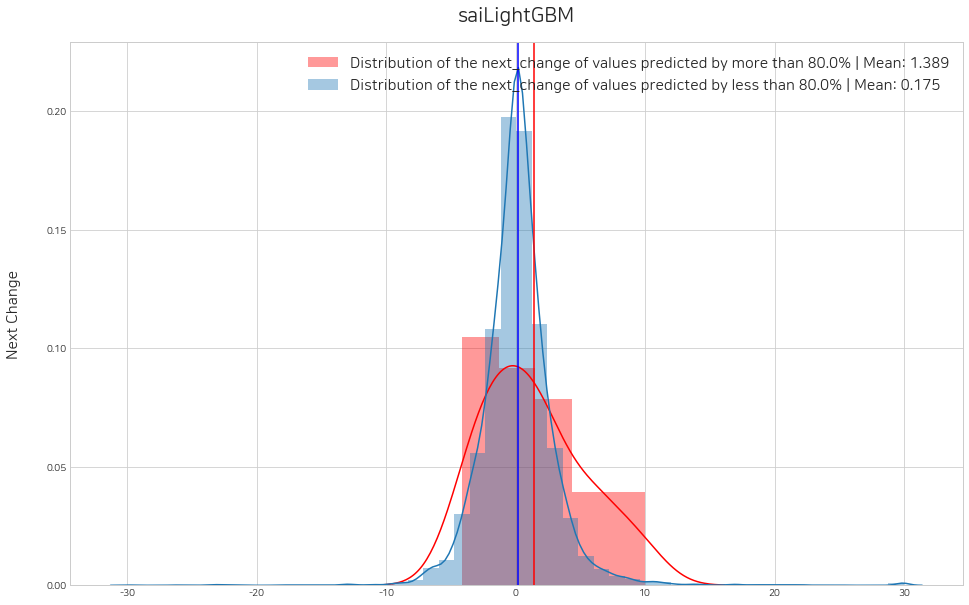

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

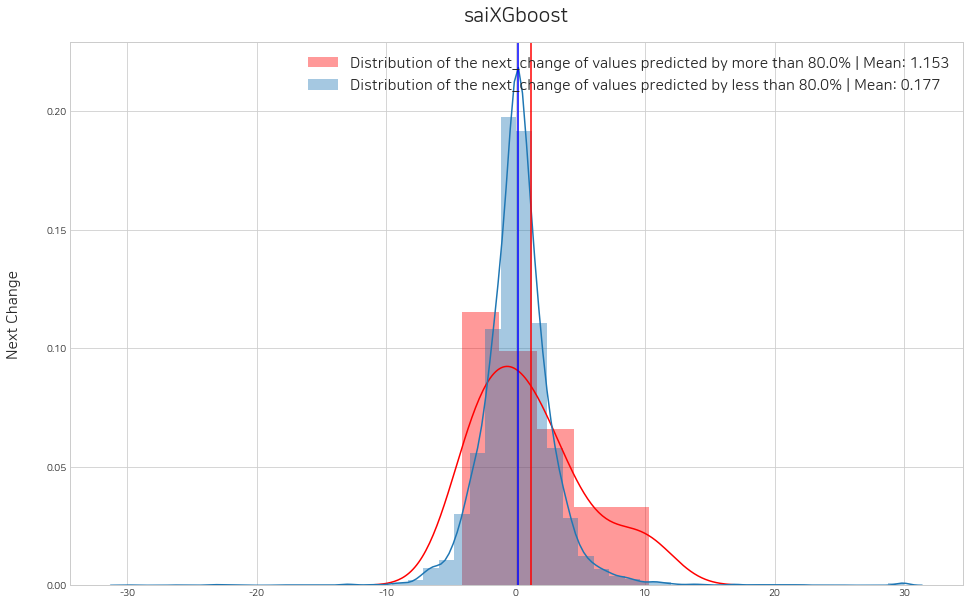

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

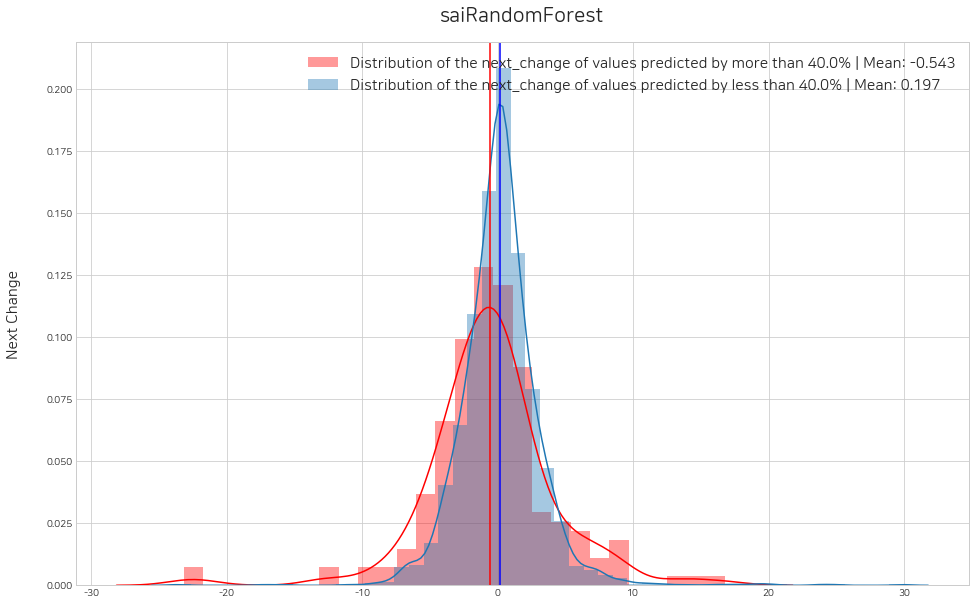

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

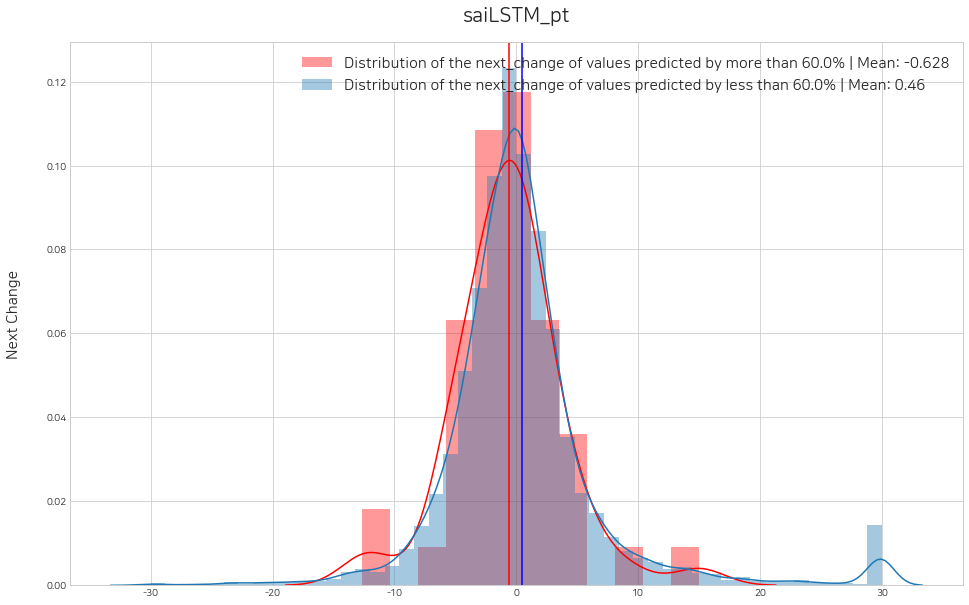

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

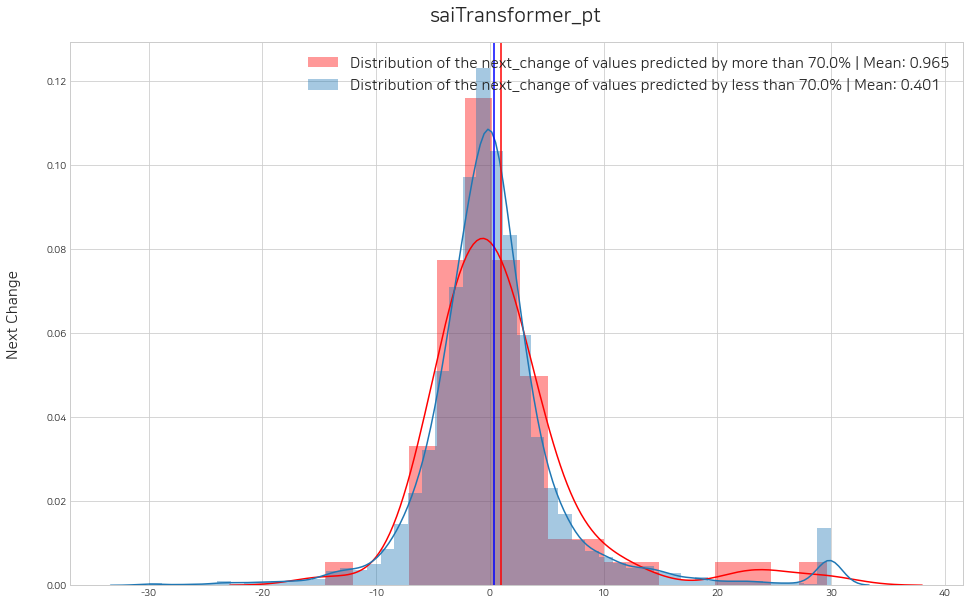

In [24]:
sai.set_threshold(lst_trader, lst_threshold=[0.8, 0.8, 0.4, 0.6, 0.7], histogram=True)

<br>
<br>

# **4. Back-Testing**

## **1) Making a sales log**
#### 각각의 트레이더로, 모든 날짜에 대한 매수, 매도 기록을 생성한 매매일지를 df_signal_all에 넣어준다.  

In [25]:
df_signal_all = sai.decision(lst_trader, dtype='test')
df_signal_all

110091it [00:06, 15932.16it/s]
110091it [00:06, 16142.24it/s]


== saiLightGBM completed ==


110091it [00:06, 17491.66it/s]
110091it [00:06, 16301.17it/s]


== saiXGboost completed ==


110091it [00:06, 16300.03it/s]
110091it [00:06, 16461.01it/s]


== saiRandomForest completed ==


110091it [00:06, 16113.96it/s]
110091it [00:06, 17488.91it/s]


== saiLSTM_pt completed ==


110091it [00:06, 16293.07it/s]
110091it [00:06, 16276.80it/s]


== saiTransformer_pt completed ==


,Trader_id,Date,Code,+(buy)/-(sell),Amount,Close
0,saiLightGBM,2021-07-01,000020,+,0.0,15800.0
1,saiLightGBM,2021-07-02,000020,+,0.0,15750.0
2,saiLightGBM,2021-07-05,000020,+,0.0,16000.0
3,saiLightGBM,2021-07-06,000020,+,0.0,15700.0
4,saiLightGBM,2021-07-07,000020,+,0.0,16100.0
...,...,...,...,...,...,...
110086,saiTransformer_pt,2021-12-24,009900,-,1.0,30600.0
110087,saiTransformer_pt,2021-12-27,009900,-,1.0,29900.0
110088,saiTransformer_pt,2021-12-28,009900,-,1.0,29400.0
110089,saiTransformer_pt,2021-12-29,009900,-,1.0,29850.0


<br>

## **2) Simulation: Calculate the yield**
#### 위에서 구한 매매일지 **df_signal_all**을 토대로 각 트레이더에 대한 수익률을 계산한다. 
#### `init_budget` 인자에 초기 예산을 입력하고, `fee` 인자에 수수료를 넣어준다. 

In [32]:
df_history_all = sai.simulation(df_signal_all, init_budget=10000000, init_stock={}, fee=0.01)
df_history_all

 99%|██████████████████████████████████████████████████████████████████████████████████▎| 124/125 [00:09<00:00, 13.62it/s]


== saiLSTM_pt completed ==


 99%|██████████████████████████████████████████████████████████████████████████████████▎| 124/125 [00:09<00:00, 13.61it/s]


== saiLightGBM completed ==


 99%|██████████████████████████████████████████████████████████████████████████████████▎| 124/125 [00:09<00:00, 13.59it/s]


== saiRandomForest completed ==


 99%|██████████████████████████████████████████████████████████████████████████████████▎| 124/125 [00:09<00:00, 13.60it/s]


== saiTransformer_pt completed ==


 99%|██████████████████████████████████████████████████████████████████████████████████▎| 124/125 [00:09<00:00, 13.64it/s]


== saiXGboost completed ==


,Trader_id,Sell_date,Budget,Yield,Stock
0,saiLSTM_pt,2021-07-01,10000000,0.000000,{}
1,saiLSTM_pt,2021-07-02,10000000,0.000000,{}
2,saiLSTM_pt,2021-07-05,10000000,0.000000,{}
3,saiLSTM_pt,2021-07-06,10000000,0.000000,{}
4,saiLSTM_pt,2021-07-07,10000000,0.000000,{}
...,...,...,...,...,...
120,saiXGboost,2021-12-24,11441976,14.419767,{}
121,saiXGboost,2021-12-27,11441976,14.419767,{}
122,saiXGboost,2021-12-28,11441976,14.419767,{}
123,saiXGboost,2021-12-29,11441976,14.419767,{}


<br>

## **3) Leader Board**
#### 트레이더의 수익률 결과를 내림차순으로 정렬하여 데이터프레임 형태의 리더보드를 볼 수 있다. 
#### 결과는 ~~ 와 같이 나왔다. 

In [33]:
sai.leaderboard(df_history_all)

,Trader_id,Yield
0,saiXGboost,14.419767
1,saiTransformer_pt,-15.552926
2,saiLightGBM,-20.818330
3,saiLSTM_pt,-23.716362
4,saiRandomForest,-79.457902


<br> 

## **4) Visualize Results**
#### 트레이더 별로 모든 날짜에 대한 수익률 시각화를 볼 수 있다. 

In [34]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

def yield_plot(df):
    
    '''
    
    [ Explanation ]
    A function that outputs a graph that visualizes returns for all traders and dates    
    
    [ input ] 
    - df: (pd.DataFrame) Sales record (df_history_all)
    
    
    [ output ]
    - df_rank: (pd.DataFrame) Yield visualization graph
    
    '''  
    
    mpl.style.use("seaborn-whitegrid")

    mpl.rcParams['font.family'] ='NanumSquareRound'
    mpl.rcParams['axes.unicode_minus'] =False
    
    
    f,ax = plt.subplots(1,1,figsize=(25,12),sharex=False)
    df = df.reset_index(drop=True)
        
    
        
    ax = sns.lineplot(data=df, x='Sell_date', y='Yield', hue='Trader_id', linewidth=4)

    _=plt.xticks(range(0, 150, 20), fontsize=20, rotation = 35)
    _=plt.yticks(range(int(df.Yield.min())-15,int(df.Yield.max())+15,20), fontsize=20)
    ax.set_xlabel('Date', fontsize=25, labelpad=25)
    ax.set_ylabel('Yield', fontsize=25, labelpad=30)
    _=plt.legend(fontsize=20)

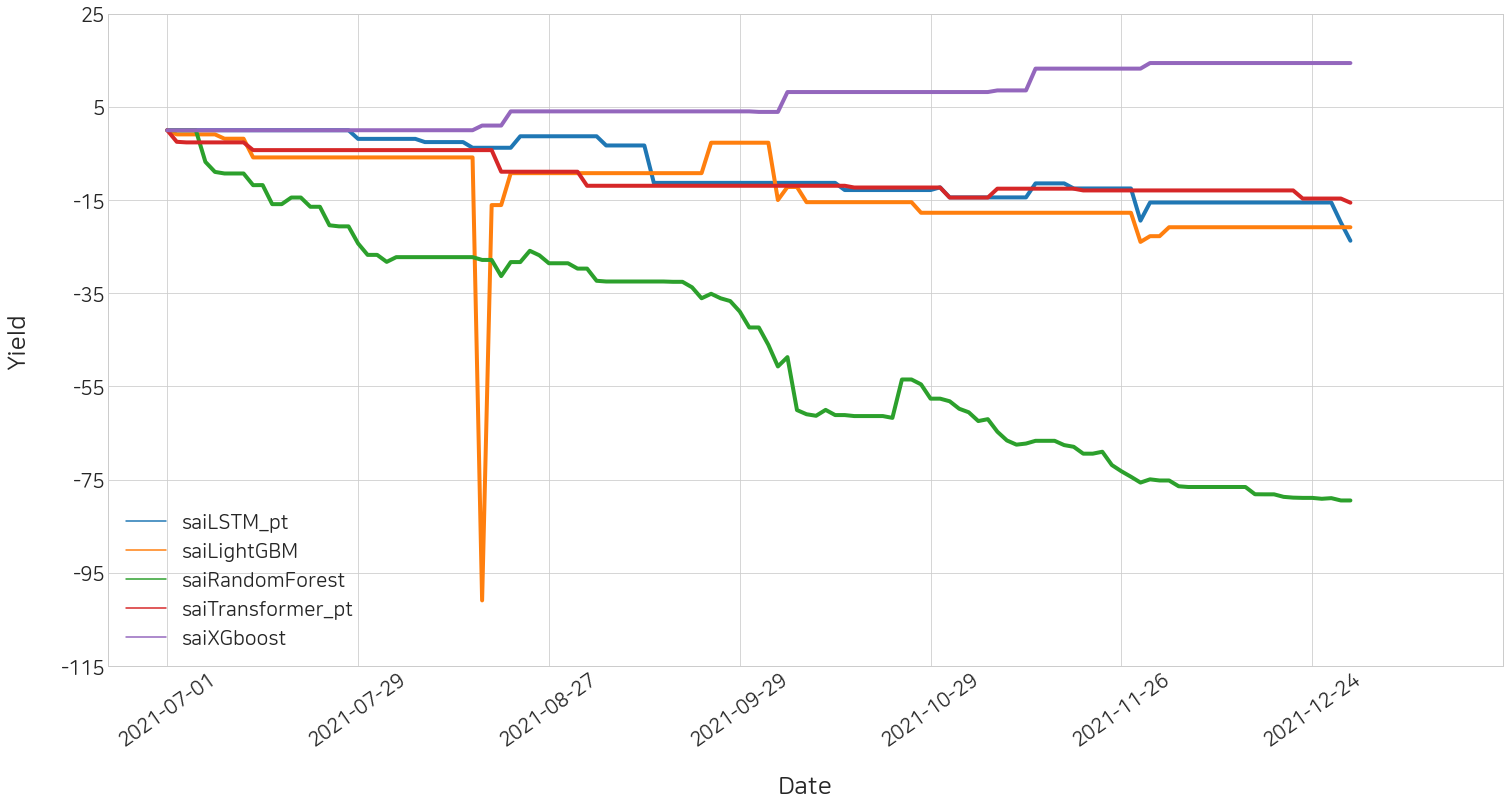

In [29]:
yield_plot(df_history_all)

#### 결과는 ~~ 이렇다 